# pySCENIC protocol: sunhye 2nd experiment

June 2020

Dataset: 2nd experiment from SHL

This notebook uses a loom file generated from the first part of the SCENIC protocol, described in: [PBMC10k_SCENIC-protocol-CLI.ipynb](https://github.com/aertslab/SCENICprotocol/blob/master/notebooks/PBMC10k_SCENIC-protocol-CLI.ipynb)

In [1]:
# import dependencies
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
from MulticoreTSNE import MulticoreTSNE as TSNE
import json
import base64
import zlib
from pyscenic.plotting import plot_binarization
from pyscenic.export import add_scenic_metadata
from pyscenic.cli.utils import load_signatures
import matplotlib as mpl
import matplotlib.pyplot as plt
# from scanpy.plotting._tools.scatterplots import plot_scatter
import seaborn as sns

/opt/miniconda3/envs/scenic_protocol/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.manifold.t_sne module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.manifold. Anything that cannot be imported from sklearn.manifold is now part of the private API.
  warnings.warn(message, FutureWarning)


#### set variables for file paths to read from and write to:

In [2]:
# set a working directory
wdir = '/home/skevin/single_cell_projects/sc_RB_devel/20171031-SHL-FACS-Hs_proj/'
os.chdir( wdir )
os.getcwd()

'/dataVolume/storage/single_cell_projects/sc_RB_devel/20171031-SHL-FACS-Hs_proj'

In [3]:
# path to loom output, generated from a combination of Scanpy and pySCENIC results:
loom_file = 'output/scenic/allfeatures_pt1_1b-1e_seu-final.loom'

adata_file = loom_file.replace("-final.loom", ".h5ad")
# adata_file = 'output/scenic/allfeatures_only_pt_w_ctrl_seu.h5ad'



In [5]:
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
# sc.logging.print_versions()
sc.settings.set_figure_params(dpi=150)

## Extract relevant data from the integrated loom file

In [6]:
# scenic output
lf = lp.connect( loom_file, mode='r', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID).T
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)

In [7]:
thresholds = {}
for i in meta['regulonThresholds']:
    j=i['regulon']
#     print(j)
    thresholds[j] = i['defaultThresholdValue']

In [8]:
# create a dictionary of regulons:
regulons = {}
for i,r in pd.DataFrame(lf.ra.Regulons,index=lf.ra.Gene).iteritems():
    regulons[i] =  list(r[r==1].index.values)

In [9]:
# capture embeddings:
dr = [
    pd.DataFrame( lf.ca.Embedding, index=lf.ca.CellID )
]
dr_names = [
    meta['embeddings'][0]['name'].replace(" ","_")
]

# add other embeddings
drx = pd.DataFrame( lf.ca.Embeddings_X, index=lf.ca.CellID )
dry = pd.DataFrame( lf.ca.Embeddings_Y, index=lf.ca.CellID )

for i in range( len(drx.columns) ):
    dr.append( pd.concat( [ drx.iloc[:,i], dry.iloc[:,i] ], sort=False, axis=1, join='outer' ))
    dr_names.append( meta['embeddings'][i+1]['name'].replace(" ","_").replace('/','-') )

# rename columns:
for i,x in enumerate( dr ):
    x.columns = ['X','Y']

In [10]:
lf.close()

# find gene length of regulons

## query n genes in any regulon

In [11]:
regulons.keys()

dict_keys(['ARID3A_(-)', 'ARID5B_(-)', 'ATF6B_(-)', 'BHLHE22_(-)', 'CEBPD_(-)', 'CENPB_(-)', 'CREBL2_(+)', 'CREM_(+)', 'CTCF_(-)', 'CUX2_(-)', 'EGR1_(-)', 'ELF2_(-)', 'ELK3_(-)', 'ESRRA_(-)', 'ETV2_(-)', 'ETV6_(-)', 'FOXG1_(-)', 'FOXL1_(-)', 'FOXO1_(-)', 'GABPA_(+)', 'GABPA_(-)', 'HEY1_(-)', 'HEY2_(+)', 'HOXB5_(-)', 'IKZF2_(-)', 'IRF2_(-)', 'IRF3_(+)', 'JUNB_(-)', 'JUND_(-)', 'KDM5B_(-)', 'KLF10_(-)', 'KLF13_(-)', 'KLF16_(-)', 'KLF2_(-)', 'KLF6_(-)', 'MAFB_(-)', 'MECOM_(-)', 'MEIS3_(-)', 'MNX1_(-)', 'MXI1_(-)', 'MYBL1_(-)', 'MYC_(-)', 'NFE2L2_(+)', 'NFIB_(-)', 'NFIC_(-)', 'NFIL3_(-)', 'NFYB_(-)', 'NR1H2_(-)', 'NR2F2_(-)', 'NR2F6_(+)', 'NRL_(-)', 'OVOL1_(-)', 'PBX1_(-)', 'PITX1_(-)', 'PKNOX1_(-)', 'PLAGL1_(-)', 'POU3F1_(-)', 'PPARA_(-)', 'RAX_(+)', 'REST_(-)', 'RFX1_(-)', 'RORA_(+)', 'RUNX1_(-)', 'RXRB_(-)', 'SIX6_(+)', 'SOX1_(-)', 'SOX8_(-)', 'SP4_(-)', 'SRF_(-)', 'TBX2_(-)', 'TFCP2_(-)', 'TGIF2_(-)', 'THAP1_(-)', 'THRB_(-)', 'USF1_(-)', 'USF2_(-)', 'YY1_(-)', 'ZBTB14_(-)', 'ZEB1_(+)',

In [12]:
myregulon = 'TBX2_(-)'

regulon_length = len(regulons[myregulon])
f"There are {regulon_length} genes in {myregulon}."

'There are 9 genes in TBX2_(-).'

## distribution of number of genes per regulon

In [13]:
import numpy as np

ncells = {key: len(value) for key, value in regulons.items()}

pd.Series([*ncells.values()]).describe()
# np.min(ncells.values())
# length_key = length_dict['key']  # length of the list stored at `'key'` ...

count    96.000000
mean     13.593750
std      10.787496
min       3.000000
25%       6.000000
50%      10.000000
75%      18.000000
max      66.000000
dtype: float64

### Alternately, we can load this data into a `scanpy.AnnData` object

This can be done directly from the integrated loom file, with a few modifications to allow for SCENIC- and SCope-specific loom attributes:

In [14]:
adata = sc.read( loom_file, validate=False)

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [15]:
# drop the embeddings and extra attributes from the obs object
adata.obs.drop( ['Embedding','Embeddings_X','Embeddings_Y','RegulonsAUC'], axis=1, inplace=True )

In [16]:
# add the embeddings into the adata.obsm object
for i,x in enumerate( dr ):
    adata.obsm[ 'X_'+dr_names[i] ] = x.values

In [17]:
sc._utils.sanitize_anndata( adata )

... storing 'ClusterID' as categorical
... storing 'Clusterings' as categorical
... storing 'Louvain_clusters_Scanpy' as categorical
... storing 'Phase' as categorical
... storing 'batch' as categorical
... storing 'branch' as categorical
... storing 'custom_cluster' as categorical
... storing 'day' as categorical
... storing 'gene_snn_res.0.2' as categorical
... storing 'gene_snn_res.0.4' as categorical
... storing 'gene_snn_res.0.6' as categorical
... storing 'gene_snn_res.0.8' as categorical
... storing 'gene_snn_res.1' as categorical
... storing 'gene_snn_res.1.2' as categorical
... storing 'gene_snn_res.1.4' as categorical
... storing 'gene_snn_res.1.6' as categorical
... storing 'gene_snn_res.1.8' as categorical
... storing 'gene_snn_res.2' as categorical
... storing 'i5_bases' as categorical
... storing 'i7_bases' as categorical
... storing 'index_i5' as categorical
... storing 'index_i7' as categorical
... storing 'louvain' as categorical
... storing 'orig.ident' as categorical

In [19]:
# cell annotations from the anndata column attributes:
cellAnnot = adata.obs

#### We can also add all metadata derived from SCENIC to the `scanpy.AnnData` object.

In [20]:
# # load the regulons from a file using the load_signatures function
# sig = load_signatures('reg.csv')
# adata = add_scenic_metadata(adata, auc_mtx, sig)

---
## Display a motifs table with motif logos

#### View the motifs table along with motif logos

In [21]:
# # helper functions (not yet integrated into pySCENIC):

# from pyscenic.utils import load_motifs
# import operator as op
# from IPython.display import HTML, display

# BASE_URL = "http://motifcollections.aertslab.org/v9/logos/"
# COLUMN_NAME_LOGO = "MotifLogo"
# COLUMN_NAME_MOTIF_ID = "MotifID"
# COLUMN_NAME_TARGETS = "TargetGenes"

# def display_logos(df: pd.DataFrame, top_target_genes: int = 3, base_url: str = BASE_URL):
#     """
#     :param df:
#     :param base_url:
#     """
#     # Make sure the original dataframe is not altered.
#     df = df.copy()
    
#     # Add column with URLs to sequence logo.
#     def create_url(motif_id):
#         return '<img src="{}{}.png" style="max-height:124px;"></img>'.format(base_url, motif_id)
#     df[("Enrichment", COLUMN_NAME_LOGO)] = list(map(create_url, df.index.get_level_values(COLUMN_NAME_MOTIF_ID)))
    
#     # Truncate TargetGenes.
#     def truncate(col_val):
#         return sorted(col_val, key=op.itemgetter(1))[:top_target_genes]
#     df[("Enrichment", COLUMN_NAME_TARGETS)] = list(map(truncate, df[("Enrichment", COLUMN_NAME_TARGETS)]))
    
#     MAX_COL_WIDTH = pd.get_option('display.max_colwidth')
#     pd.set_option('display.max_colwidth', 200)
#     display(HTML(df.head().to_html(escape=False)))
#     pd.set_option('display.max_colwidth', MAX_COL_WIDTH)

In [22]:
# df_motifs = load_motifs('reg.csv')

In [23]:
# selected_motifs = ['PAX5','TCF3','EBF1']
# df_motifs_sel = df_motifs.iloc[ [ True if x in selected_motifs else False for x in df_motifs.index.get_level_values('TF') ] ,:]

In [24]:
# #display_logos(df_motifs.head())
# display_logos( df_motifs_sel.sort_values([('Enrichment','NES')], ascending=False).head(9))

---
# Dimensionality reduction plots

### Alternately, we can plot two dimensionality reductions side-by-side

(this uses non-Scanpy plotting functions)

In [25]:
def colorMap( x, palette='bright' ):
    import natsort
    from collections import OrderedDict
    #
    n=len(set(x))
    cpalette = sns.color_palette(palette,n_colors=n )
    cdict = dict( zip( list(set(x)), cpalette ))
    cmap = [ cdict[i] for i in x ]
    cdict = OrderedDict( natsort.natsorted(cdict.items()) )
    return cmap,cdict

def drplot( dr, colorlab, ax, palette='bright', title=None, **kwargs ):
    cmap,cdict = colorMap( colorlab, palette )
    for lab,col in cdict.items():  
        ix = colorlab.loc[colorlab==lab].index
        ax.scatter( dr['X'][ix], dr['Y'][ix], c=[col]*len(ix), alpha=0.7, label=lab, edgecolors='none')
    if( title is not None ):
        ax.set_title(title, fontsize='x-large');
    #
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)


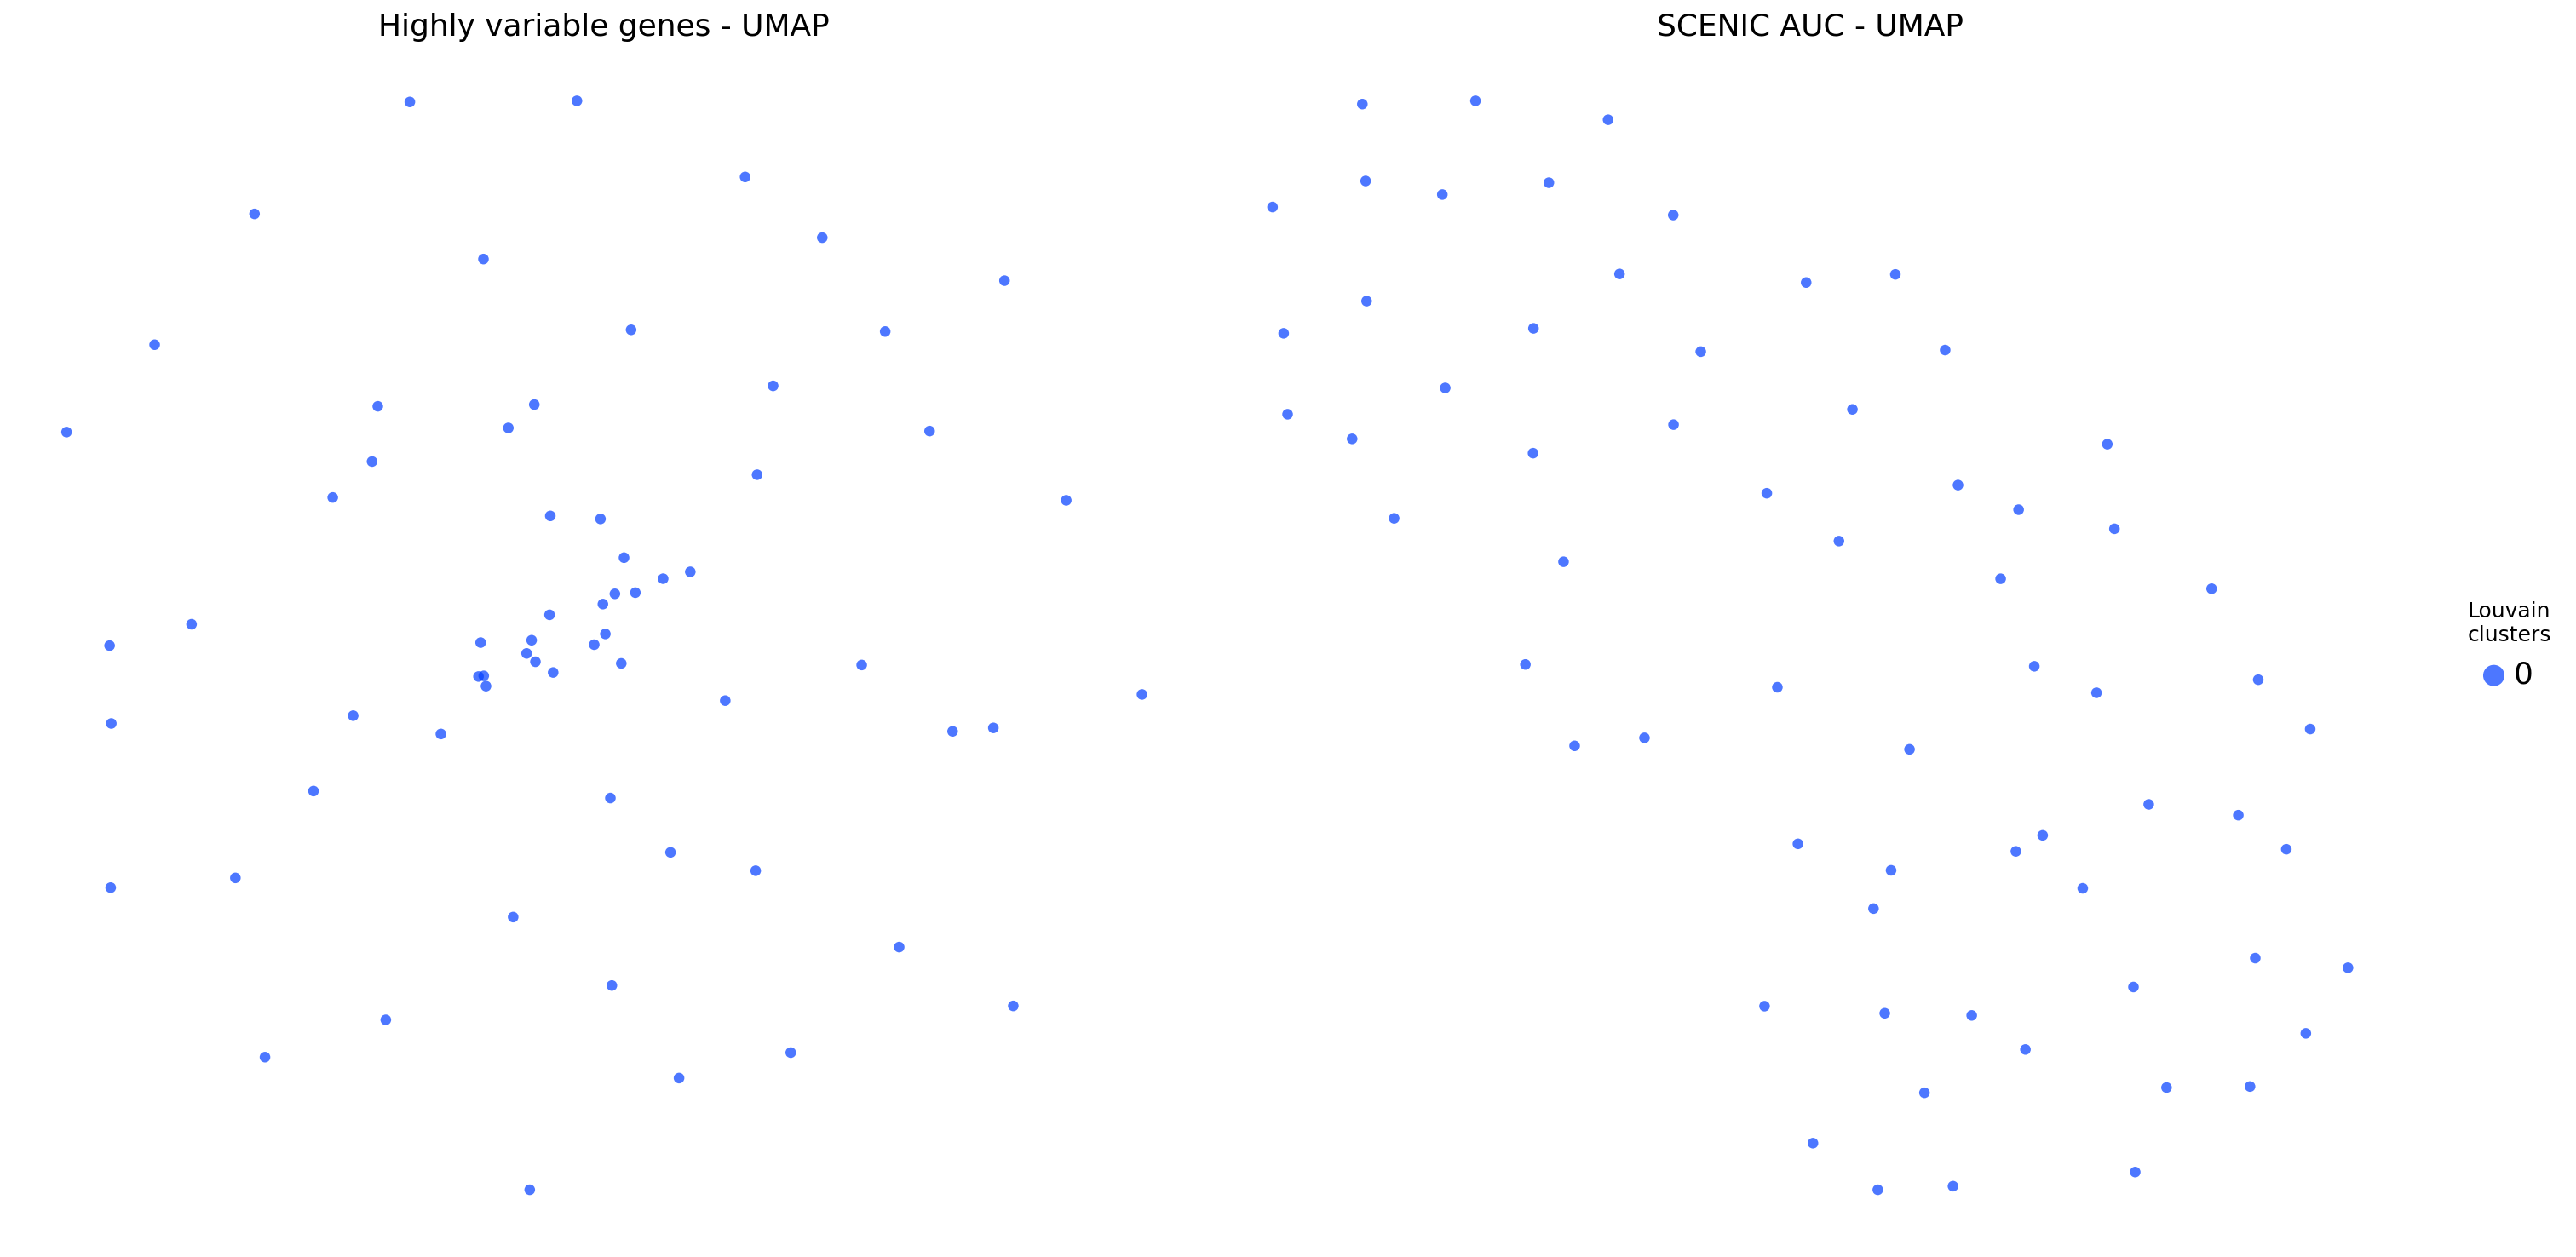

In [26]:
plt.rcParams.update({'font.size':12})

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10), dpi=150 )

drplot( dr[0], colorlab=cellAnnot['Louvain_clusters_Scanpy'], ax=ax1, palette='bright', s=2, title='Highly variable genes - UMAP' )

drplot( dr[4], colorlab=cellAnnot['Louvain_clusters_Scanpy'], ax=ax2, palette='bright', s=2, title='SCENIC AUC - UMAP' )
ax2.legend(loc='right', bbox_to_anchor=(1.15, 0.5), ncol=1, markerscale=2, fontsize='x-large', frameon=False, title="Louvain\nclusters")

plt.tight_layout()
plt.savefig("PBMC10k_dimred_umap-hvg-scenic-louvain.pdf", dpi=600, bbox_inches = "tight")

In [27]:
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_rss
import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns
from pyscenic.binarization import binarize

### RSS panel plot with all cell types

In [28]:
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center')
    return f

# Regulon specificity scores (RSS) across cell metadata

## Metadata = Louvain clusters at resolution 1.6

In [29]:
metavar="pt1_clusters"

### Calculate RSS

In [30]:
rss_louvain = regulon_specificity_scores( auc_mtx, cellAnnot[metavar] )
rss_louvain

ARID3A_(-)  ARID5B_(-)  ATF6B_(-)  BHLHE22_(-)  CEBPD_(-)  CENPB_(-)  \
1c    0.282519    0.312070   0.323596     0.329493   0.335304   0.337052   
1b    0.333150    0.300816   0.307347     0.278382   0.305151   0.279590   
id    0.404618    0.391777   0.406560     0.342246   0.434483   0.411044   
1e    0.460208    0.471948   0.454289     0.384323   0.378011   0.450269   

    CREBL2_(+)  CREM_(+)  CTCF_(-)  CUX2_(-)  ...  ZNF454_(-)  ZNF568_(-)  \
1c    0.270546  0.307421  0.251002  0.260927  ...    0.282281    0.268192   
1b    0.313136  0.317216  0.191477  0.270207  ...    0.271937    0.291283   
id    0.363260  0.363909  0.387472  0.357447  ...    0.353365    0.367418   
1e    0.451662  0.422481  0.320450  0.405317  ...    0.453768    0.370613   

    ZNF594_(-)  ZNF597_(-)  ZNF607_(-)  ZNF610_(-)  ZNF664_(-)  ZNF699_(-)  \
1c    0.297803    0.298815    0.287618    0.250798    0.201968    0.277277   
1b    0.308443    0.331736    0.311279    0.232503    0.208515    0.282757   
id    0.427587    0.415754    0.245381    0.392027    0.364241    0.261993   
1e    0.430125    0.400056    0.379085    0.425417    0.371633    0.382000   

    ZNF841_(-)  ZNF860_(-)  
1c    0.261084    0.299660  
1b    0.333153    0.294122  
id    0.255985    0.375568  
1e    0.314982    0.464470  

[4 rows x 96 columns]

In [31]:
rss_louvain.to_csv('output/scenic/RSS_specificity_scores.csv', index = False)

### RSS panel plot with all louvain clusters

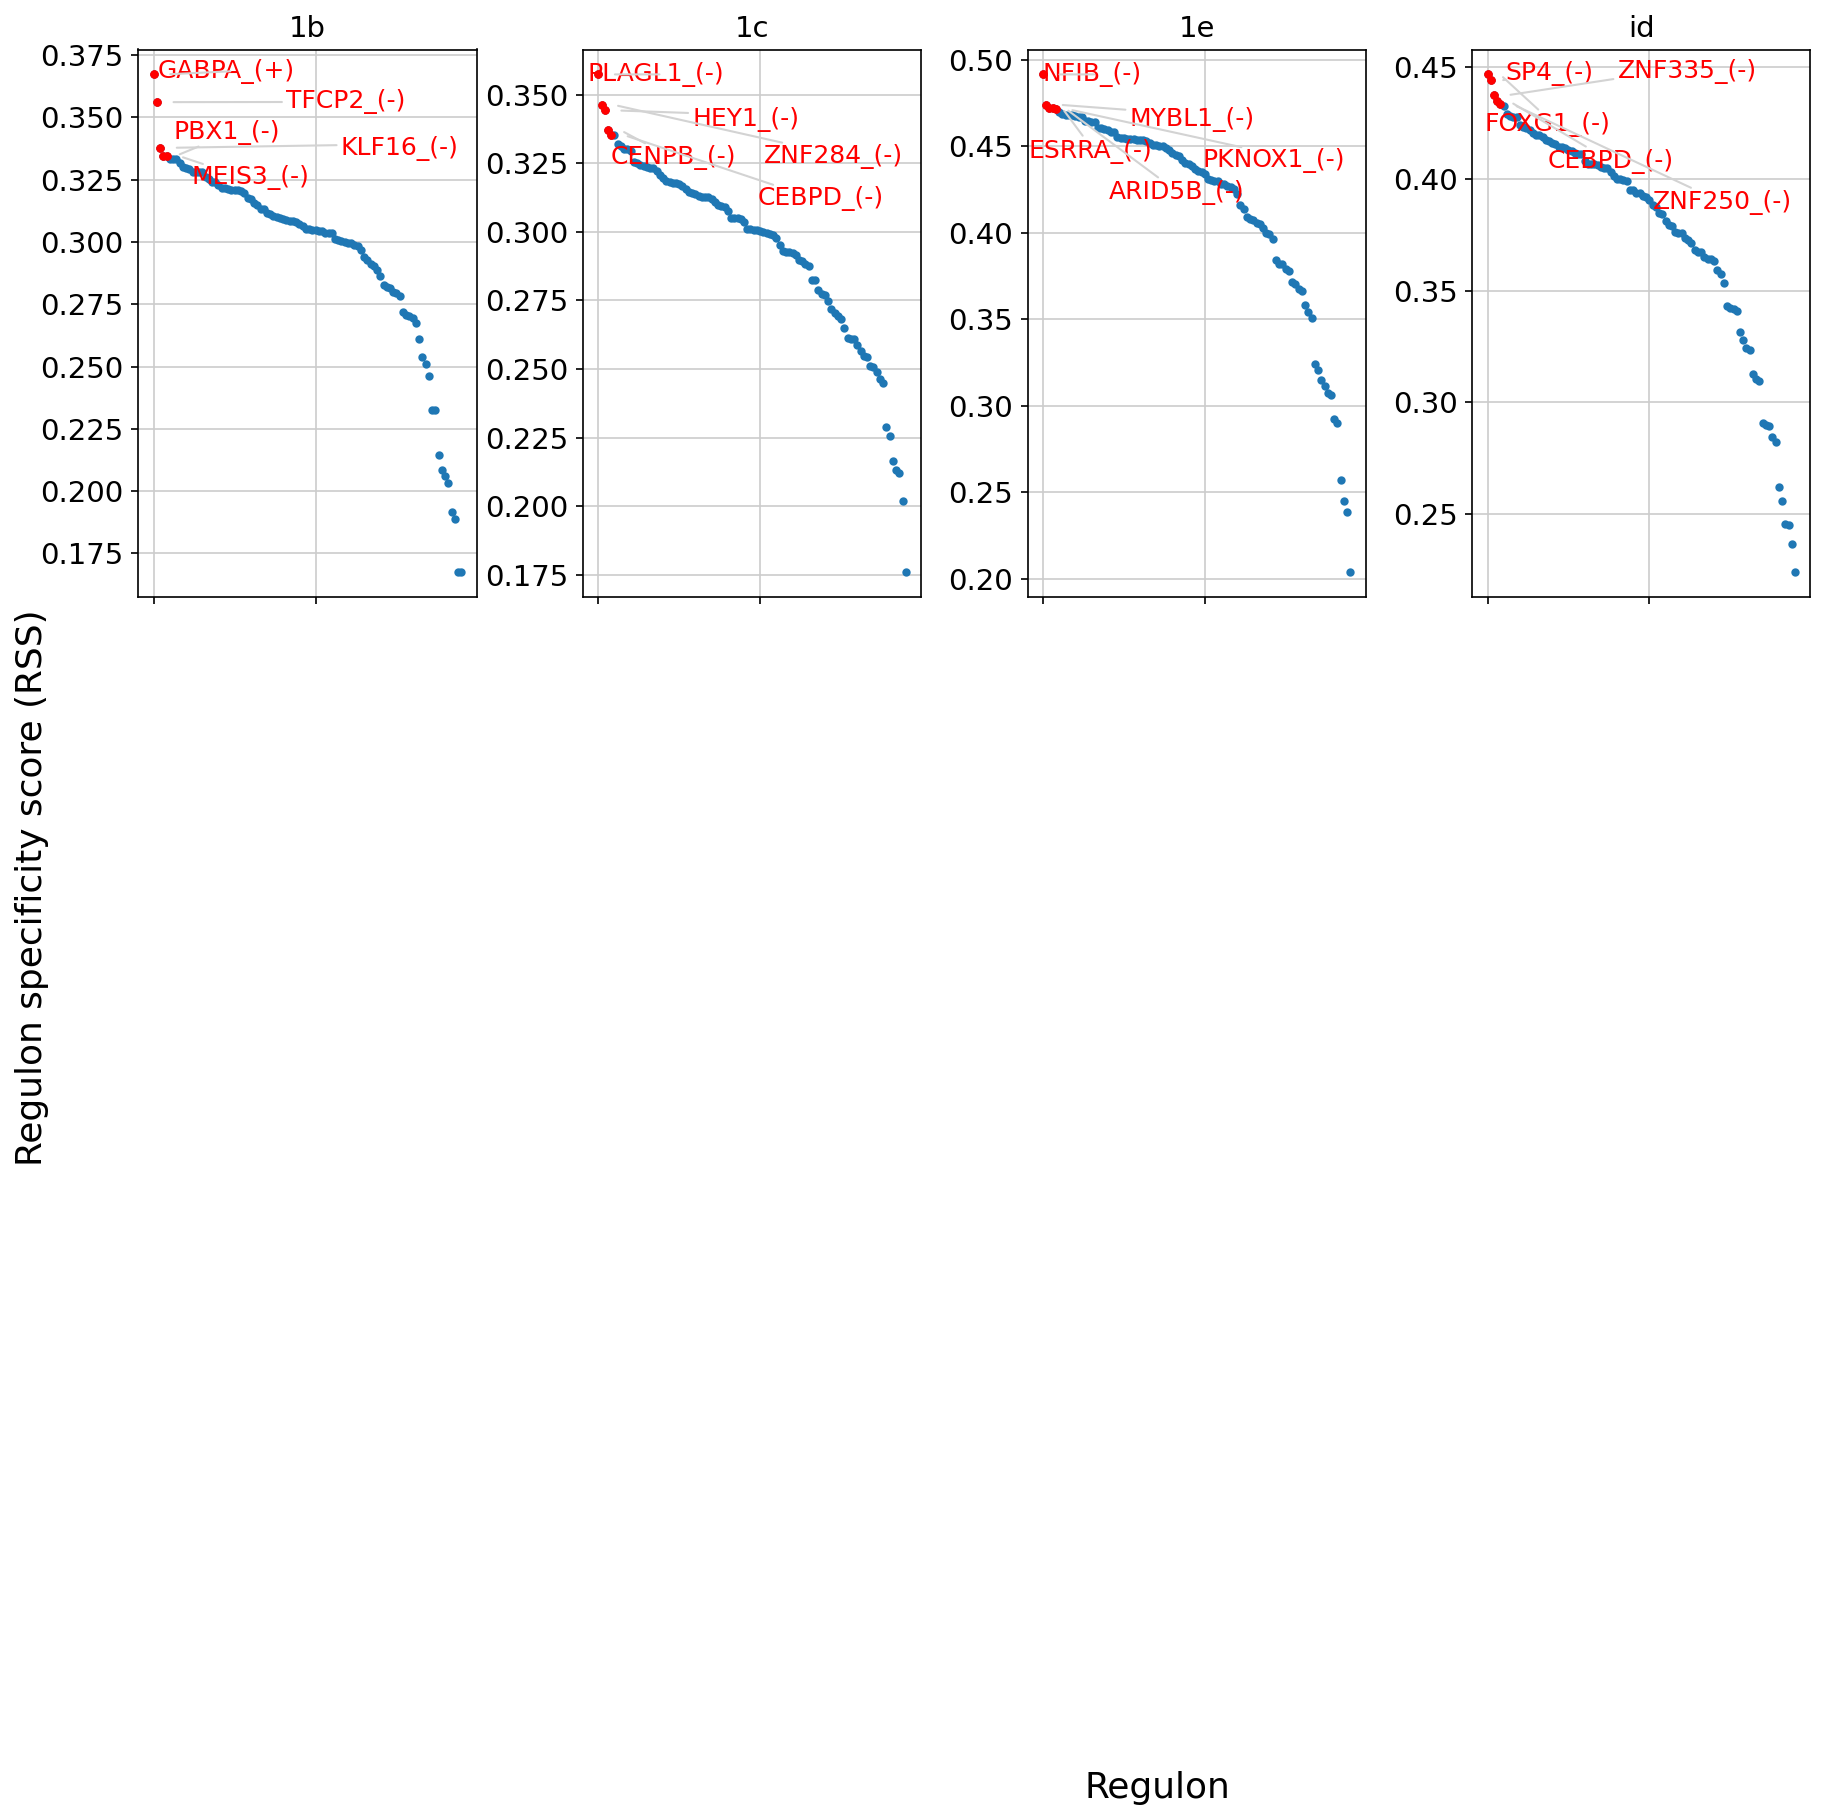

In [32]:
cats = sorted( list(set(cellAnnot[metavar].dropna())) )

fig = plt.figure(figsize=(15, 12))
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss_louvain.T[c]
    ax = fig.add_subplot(3,5,num)
    plot_rss(rss_louvain, c, top_n=5, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )
 
fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
        'figure.titlesize': 'large' ,
        'axes.labelsize': 'medium',
        'axes.titlesize':'large',
        'xtick.labelsize':'medium',
        'ytick.labelsize':'medium'
        })
plt.savefig("PBMC10k_Louvain-RSS-top5.png", dpi=150, bbox_inches = "tight")
plt.show()

### Select the top 5 regulons from each louvain cluster

In [33]:
topreg = []
for i,c in enumerate(cats):
    topreg.extend(
        list(rss_louvain.T[c].sort_values(ascending=False)[:5].index)
    )
topreg = list(set(topreg))

# Calculate mean AUC per cluster

In [34]:
topreg
auc_meta = pd.merge(adata.obs, auc_mtx, how = "left", left_index = True, right_index = True)
# adata.obs["integrated_snn_res.1.6"].value_counts()
# auc_mtx
mean_regulon_by_meta = auc_meta.groupby(metavar)[topreg].mean()
mean_regulon_by_meta

HEY1_(-)  ESRRA_(-)  ZNF284_(-)  PBX1_(-)  PLAGL1_(-)  \
pt1_clusters                                                          
1b            0.065613   0.069553    0.058610  0.070867    0.072474   
1c            0.075046   0.066947    0.073626  0.074155    0.102711   
1e            0.055867   0.084729    0.043393  0.055265    0.079708   
id            0.052020   0.075300    0.042270  0.053523    0.047058   

              GABPA_(+)  NFIB_(-)  ARID5B_(-)  ZNF335_(-)  MEIS3_(-)  \
pt1_clusters                                                           
1b             0.023579  0.072817    0.097199    0.033378   0.132965   
1c             0.008723  0.072210    0.109540    0.051169   0.133277   
1e             0.008057  0.103773    0.114126    0.050514   0.090406   
id             0.016355  0.080530    0.102534    0.057412   0.086199   

              CEBPD_(-)  CENPB_(-)  MYBL1_(-)  PKNOX1_(-)  KLF16_(-)  \
pt1_clusters                                                           
1b             0.086878   0.108809   0.190128    0.167943   0.218482   
1c             0.107010   0.173426   0.192340    0.186430   0.105234   
1e             0.066952   0.144647   0.198145    0.186788   0.183410   
id             0.103768   0.149984   0.128163    0.154567   0.166028   

              TFCP2_(-)  ZNF250_(-)  FOXG1_(-)   SP4_(-)  
pt1_clusters                                              
1b             0.070567    0.043773   0.125574  0.048446  
1c             0.021858    0.044652   0.125362  0.039064  
1e             0.031972    0.067132   0.113487  0.035936  
id             0.066064    0.072180   0.155702  0.054802

#### Generate a Z-score for each regulon to enable comparison between regulons

In [35]:
auc_mtx_Z = pd.DataFrame( index=auc_mtx.index )
for col in list(auc_mtx.columns):
    auc_mtx_Z[ col ] = ( auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)
#auc_mtx_Z.sort_index(inplace=True)

#### Generate a heatmap

In [36]:
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center')
    return f

In [37]:
cellAnnot.index = cellAnnot.index.str.replace("ds20170407_S", "ds20170407-")
cellAnnot = cellAnnot.sort_values(metavar)
cellAnnot.index

Index(['shl20171031-053', 'shl20171031-061', 'shl20171031-063',
       'shl20171031-070', 'shl20171031-419', 'shl20171031-156',
       'shl20171031-173', 'shl20171031-416', 'shl20171031-234',
       'shl20171031-250', 'shl20171031-045', 'shl20171031-350',
       'shl20171031-349', 'shl20171031-330', 'shl20171031-318',
       'shl20171031-331', 'shl20171031-263', 'shl20171031-262',
       'shl20171031-133', 'shl20171031-268', 'shl20171031-455',
       'shl20171031-510', 'shl20171031-516', 'shl20171031-518',
       'shl20171031-523', 'shl20171031-527', 'shl20171031-531',
       'shl20171031-548', 'shl20171031-534', 'shl20171031-538',
       'shl20171031-539', 'shl20171031-540', 'shl20171031-547',
       'shl20171031-545', 'shl20171031-541', 'shl20171031-451',
       'shl20171031-542', 'shl20171031-537', 'shl20171031-448',
       'shl20171031-550', 'shl20171031-442', 'shl20171031-440',
       'shl20171031-433', 'shl20171031-431', 'shl20171031-549',
       'shl20171031-444', 'shl20171031-2

In [38]:
auc_mtx = auc_mtx.reindex(cellAnnot.index)

In [39]:
cats

['1b', '1c', '1e', 'id']

In [40]:
colors = sns.color_palette('bright',n_colors=len(cats) )
colorsd = dict( zip( cats, colors ))
colormap = [ colorsd[x] for x in cellAnnot[metavar].dropna() ]

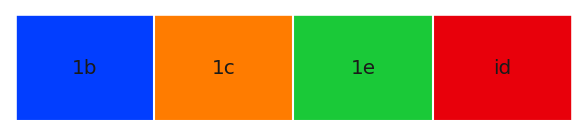

In [41]:
sns.set()
sns.set(font_scale=0.8)
fig = palplot( colors, cats, size=1.0)

Text(0.5, -103.80833333333341, '')

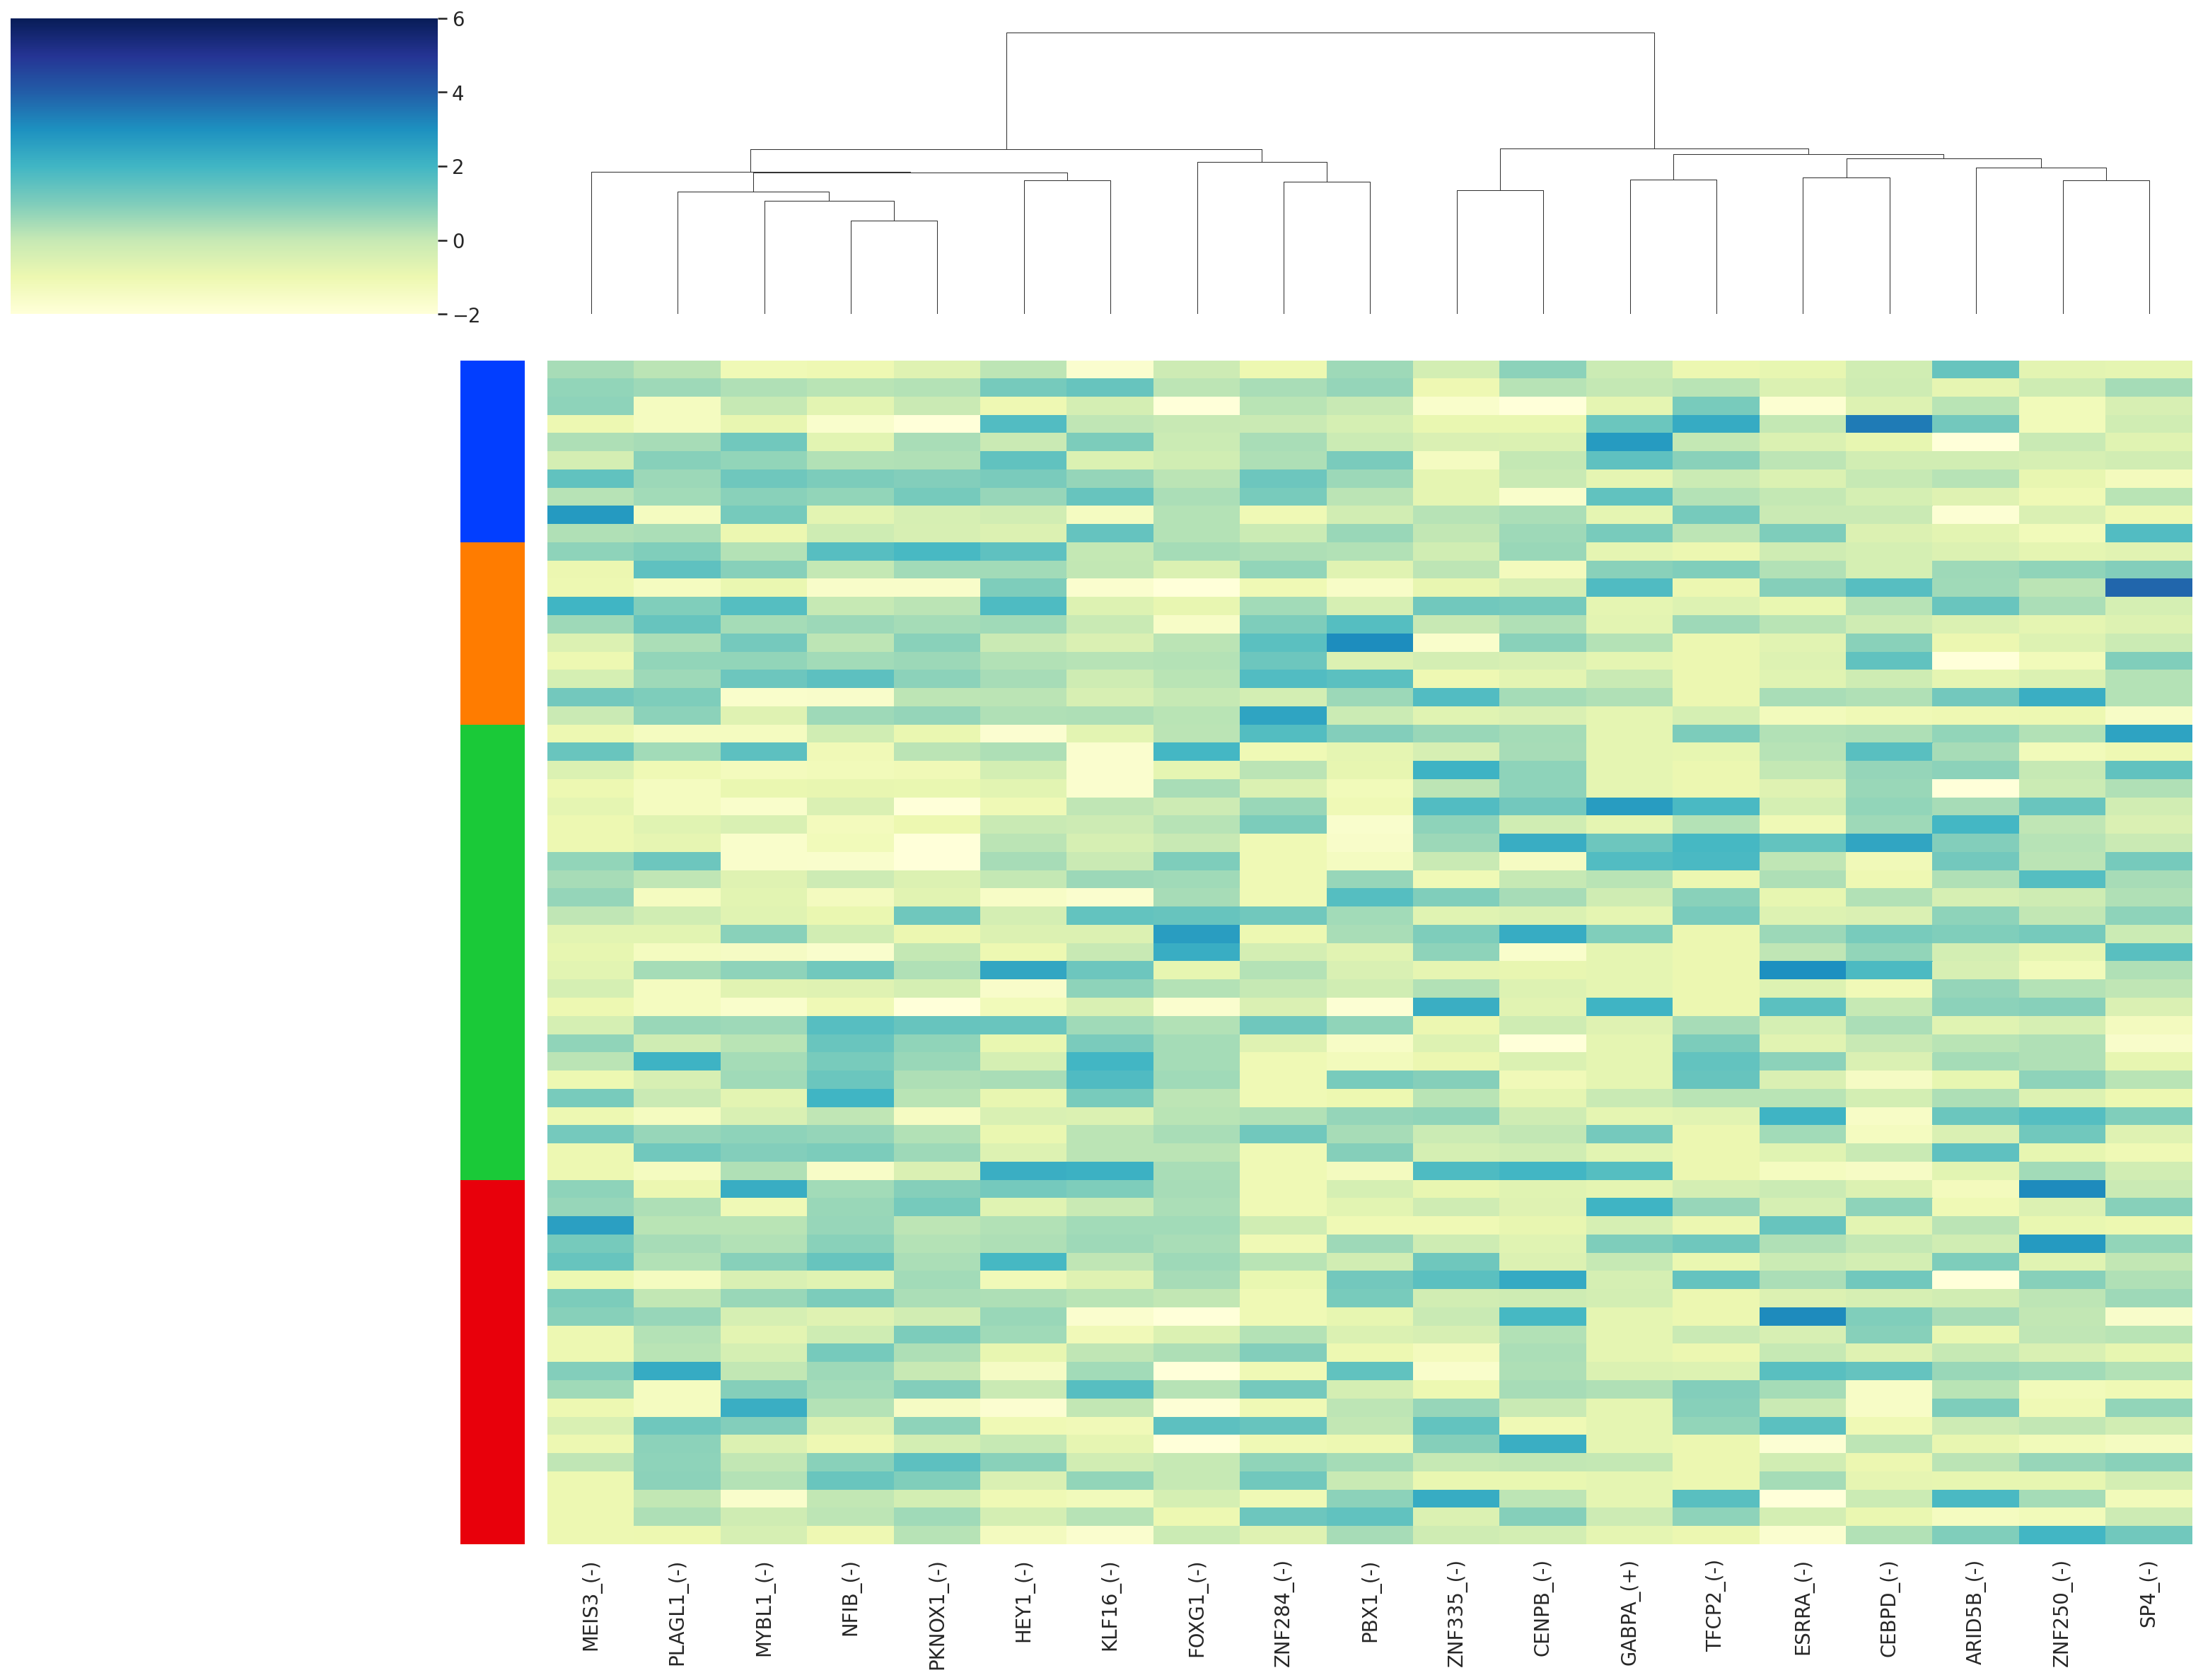

In [42]:
# change row_cluster argument to cluster by ward or else order by specified cell metadata (whatever is currently assigned to metavar)

sns.set(font_scale=1.2)
g = sns.clustermap(auc_mtx_Z[topreg], mask=False,  square=False,  linecolor='gray',
    yticklabels=False, vmin=-2, vmax=6, row_colors=colormap, row_cluster=False, method = 'ward',
    cmap="YlGnBu", figsize=(21,16) )
g.cax.set_visible(True)
g.ax_heatmap.set_ylabel('')    
g.ax_heatmap.set_xlabel('')    

In [43]:
g.savefig('scenic_heatmap.png', dpi=600, bbox_inches='tight')

### Generate a binary regulon activity matrix:

In [44]:
from timeit import default_timer as timer
from datetime import timedelta

start = timer()
end = timer()
print(timedelta(seconds=end-start))

0:00:00.000017


In [45]:
binary_mtx, auc_thresholds = binarize(auc_mtx, num_workers=6)
binary_mtx.head()

ARID3A_(-)  ARID5B_(-)  ATF6B_(-)  BHLHE22_(-)  CEBPD_(-)  \
shl20171031-053           0           0          0            0          0   
shl20171031-061           0           0          0            0          0   
shl20171031-063           0           0          0            0          1   
shl20171031-070           0           0          0            1          0   
shl20171031-419           0           0          0            0          0   

                 CENPB_(-)  CREBL2_(+)  CREM_(+)  CTCF_(-)  CUX2_(-)  ...  \
shl20171031-053          0           0         0         0         1  ...   
shl20171031-061          0           0         0         0         0  ...   
shl20171031-063          0           0         0         0         0  ...   
shl20171031-070          0           0         0         0         0  ...   
shl20171031-419          0           0         0         0         0  ...   

                 ZNF454_(-)  ZNF568_(-)  ZNF594_(-)  ZNF597_(-)  ZNF607_(-)  \
shl20171031-053           0           1           0           0           0   
shl20171031-061           1           0           0           0           0   
shl20171031-063           0           0           0           1           1   
shl20171031-070           0           1           0           0           0   
shl20171031-419           0           0           0           0           1   

                 ZNF610_(-)  ZNF664_(-)  ZNF699_(-)  ZNF841_(-)  ZNF860_(-)  
shl20171031-053           0           0           1           0           0  
shl20171031-061           1           0           0           1           0  
shl20171031-063           0           0           0           1           0  
shl20171031-070           0           0           0           0           0  
shl20171031-419           0           0           0           0           0  

[5 rows x 96 columns]

### Show the AUC distributions for selected regulons

/opt/miniconda3/envs/scenic_protocol/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/miniconda3/envs/scenic_protocol/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/miniconda3/envs/scenic_protocol/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-l

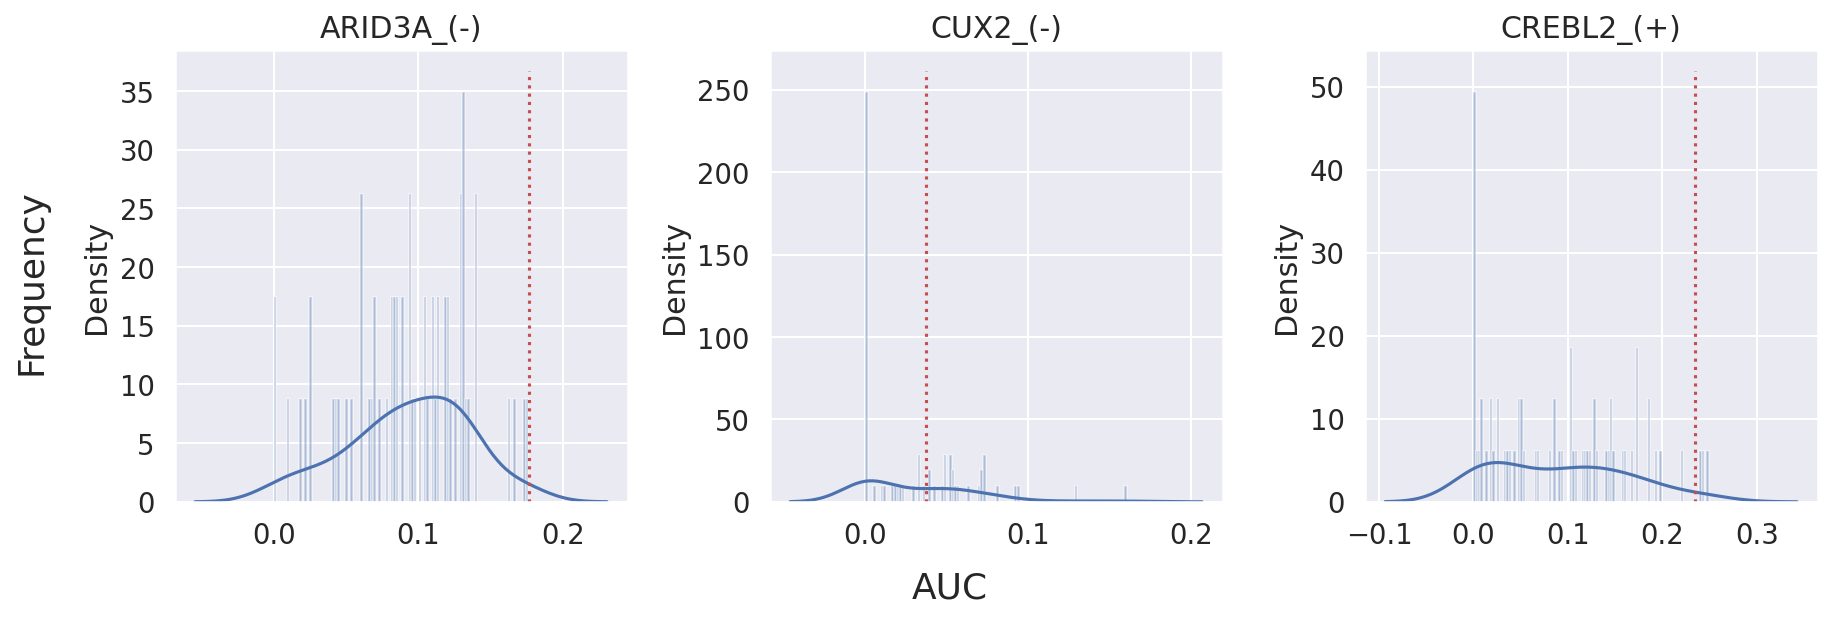

In [46]:
# select regulons:
r = [ 'ARID3A_(-)', 'CUX2_(-)', 'CREBL2_(+)' ]

fig, axs = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=False)
for i,ax in enumerate(axs):
    sns.distplot(auc_mtx[ r[i] ], ax=ax, norm_hist=True, bins=100)
    ax.plot( [ thresholds[ r[i] ] ]*2, ax.get_ylim(), 'r:')
    ax.title.set_text( r[i] )
    ax.set_xlabel('') 
fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='large')
fig.text(0.5, -0.01, 'AUC', ha='center', va='center', rotation='horizontal', size='large')

fig.tight_layout()
fig.savefig('output/scenic/scenic-binaryPlot.pdf', dpi=600, bbox_inches='tight')

# display regulon scores on umap

In [47]:
adata_h5ad.obs[auc_mtx.columns] = auc_mtx

In [48]:
adata_h5ad.obs

orig.ident    nCount_RNA  nFeature_RNA     day  \
shl20171031-045  shl20171031  4.974402e+06          9700   day_3   
shl20171031-053  shl20171031  5.837802e+06         11206   day_3   
shl20171031-061  shl20171031  4.396667e+06          8897   day_3   
shl20171031-063  shl20171031  4.352046e+06          8686   day_3   
shl20171031-070  shl20171031  4.030277e+06         11003   day_3   
...                      ...           ...           ...     ...   
shl20171031-545  shl20171031  4.010407e+06         11076  day_15   
shl20171031-547  shl20171031  5.898742e+06         10019  day_15   
shl20171031-548  shl20171031  4.751634e+06          8478  day_15   
shl20171031-549  shl20171031  4.412243e+06         11309  day_15   
shl20171031-550  shl20171031  4.086102e+06          7214  day_15   

                treatment_group index_i7  i7_bases index_i5  i5_bases  lane  \
shl20171031-045           sh733     N706  TAGGCATG     S507  TACTCCTT   2.0   
shl20171031-053           sh733     N707  CTCTCTAC     S507  TACTCCTT   2.0   
shl20171031-061           sh733     N710  CGAGGCTG     S507  TACTCCTT   2.0   
shl20171031-063           sh733     N710  CGAGGCTG     S510  ATTAGACG   2.0   
shl20171031-070           sh737     N711  AAGAGGCA     S508  AGGCTTAG   3.0   
...                         ...      ...       ...      ...       ...   ...   
shl20171031-545           sh737     N710  CGAGGCTG     S516  ACTCTAGG   6.0   
shl20171031-547           sh737     N710  CGAGGCTG     S518  CTTAATAG   6.0   
shl20171031-548           sh737     N710  CGAGGCTG     S520  ATAGCCTT   6.0   
shl20171031-549           sh737     N710  CGAGGCTG     S521  TAAGGCTC   6.0   
shl20171031-550           sh737     N710  CGAGGCTG     S522  TCGCATAA   6.0   

                 ... ZNF454_(-) ZNF568_(-)  ZNF594_(-) ZNF597_(-) ZNF607_(-)  \
shl20171031-045  ...   0.196170   0.000000    0.000000   0.178936   0.034553   
shl20171031-053  ...   0.000000   0.041571    0.075603   0.095000   0.000000   
shl20171031-061  ...   0.157447   0.007660    0.000000   0.114362   0.000000   
shl20171031-063  ...   0.000000   0.019509    0.082695   0.268830   0.052000   
shl20171031-070  ...   0.000000   0.061211    0.100426   0.131064   0.004255   
...              ...        ...        ...         ...        ...        ...   
shl20171031-545  ...   0.210638   0.042946    0.128085   0.000000   0.048596   
shl20171031-547  ...   0.198511   0.020229    0.153901   0.000000   0.000000   
shl20171031-548  ...   0.000000   0.000000    0.000000   0.203404   0.000000   
shl20171031-549  ...   0.187447   0.000000    0.091348   0.076170   0.000000   
shl20171031-550  ...   0.000000   0.000000    0.118865   0.080851   0.000000   

                ZNF610_(-) ZNF664_(-) ZNF699_(-) ZNF841_(-) ZNF860_(-)  
shl20171031-045   0.000000   0.000000   0.000000   0.097447   0.030809  
shl20171031-053   0.044255   0.000000   0.077163   0.031489   0.056340  
shl20171031-061   0.085248   0.042128   0.020142   0.104255   0.016340  
shl20171031-063   0.000000   0.000000   0.000000   0.129149   0.167149  
shl20171031-070   0.067234   0.058865   0.024397   0.000000   0.001872  
...                    ...        ...        ...        ...        ...  
shl20171031-545   0.000000   0.016596   0.320142   0.000000   0.095915  
shl20171031-547   0.015745   0.000000   0.101277   0.058085   0.156851  
shl20171031-548   0.000000   0.000000   0.000000   0.034894   0.064681  
shl20171031-549   0.039007   0.000000   0.000000   0.000000   0.066638  
shl20171031-550   0.215745   0.000000   0.000000   0.000000   0.000000  

[65 rows x 147 columns]

In [49]:
# mean_regulon_by_meta.loc[:,"CREB3_(+)"]

In [50]:
adata_pca = pd.read_csv("output/scenic/martin_pc_output.csv", index_col = 0)
adata_pca.index

Index(['shl20171031-108', 'shl20171031-109', 'shl20171031-110',
       'shl20171031-111', 'shl20171031-112', 'shl20171031-113',
       'shl20171031-114', 'shl20171031-115', 'shl20171031-116',
       'shl20171031-117',
       ...
       'shl20171031-073', 'shl20171031-074', 'shl20171031-075',
       'shl20171031-076', 'shl20171031-077', 'shl20171031-078',
       'shl20171031-079', 'shl20171031-082', 'shl20171031-083',
       'shl20171031-085'],
      dtype='object', length=260)

In [52]:
myindex = adata_h5ad.obs.index
adata_pca0 = adata_pca.loc[myindex,]
adata_pca = adata_pca0.to_numpy()

In [53]:
# pd.DataFrame(adata_h5ad.obsm['X_pca']).shape
adata_h5ad.obsm['X_pca'][:,:20] = adata_pca

In [56]:
first_regulons = range(0,(len(auc_mtx.columns)//2))
second_regulons = range(len(auc_mtx.columns)//2, len(auc_mtx.columns))

/home/skevin/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


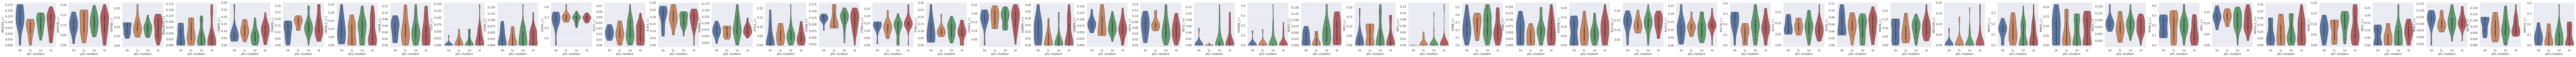

In [57]:
adata_h5ad.obs.pt1_clusters

sc.pl.violin(adata_h5ad, keys=auc_mtx.columns[first_regulons], multi_panel = True, groupby="pt1_clusters", log=False, stripplot=True, size = 2, inner = "box")

In [58]:
sc.pl.violin(adata_h5ad, keys=auc_mtx.columns[second_regulons, multi_panel = True, groupby="pt1_clusters", log=False, stripplot=True, size = 2, inner = "box")

SyntaxError: invalid syntax (<ipython-input-58-e79b106ece3d>, line 1)

In [59]:
sc.pl.violin(adata_h5ad, keys=auc_mtx.columns, multi_panel = True, groupby="pt2_clusters", log=False, stripplot=True, size = 2, inner = "box")

ValueError: Image size of 67003x600 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 67003.2x600 with 96 Axes>

/opt/miniconda3/envs/scenic_protocol/lib/python3.6/site-packages/scanpy/plotting/_utils.py:287: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.savefig(filename, dpi=dpi, bbox_inches='tight')
/home/skevin/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


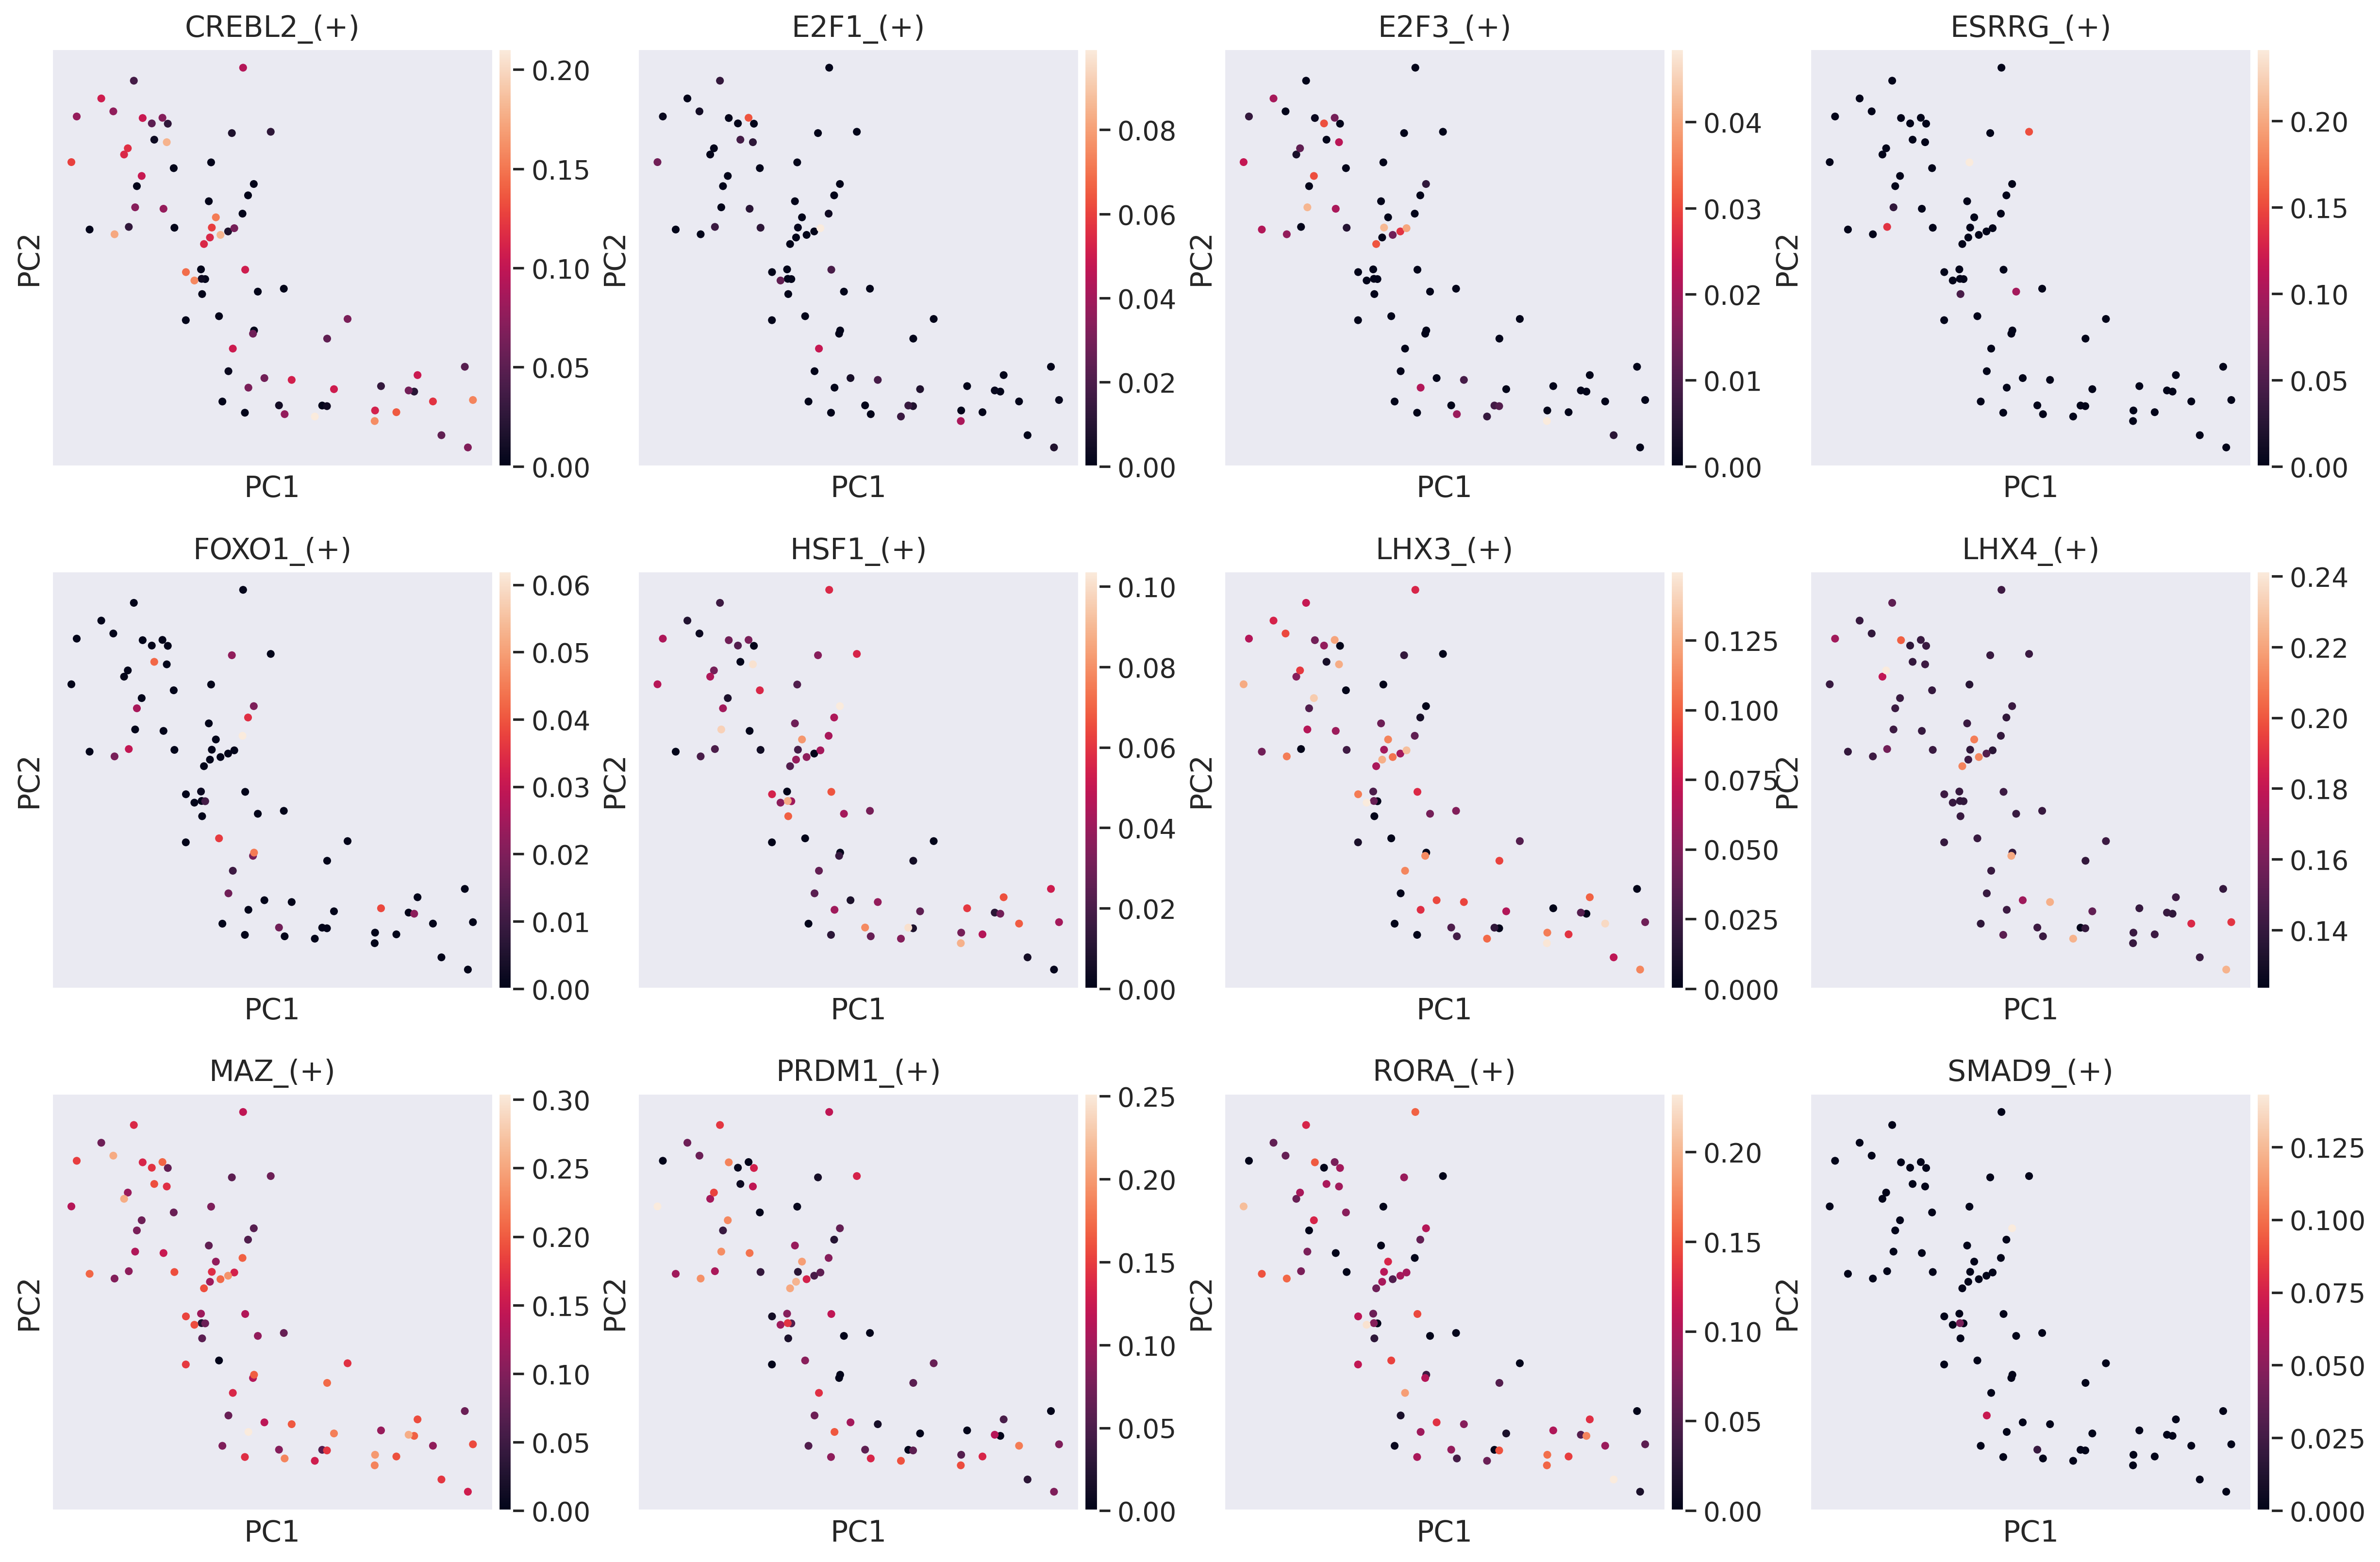

In [75]:
sc.pl.pca(adata_h5ad, components = ['1,2'], color=auc_mtx.columns, size=60, save='.pdf')

/opt/miniconda3/envs/scenic_protocol/lib/python3.6/site-packages/scanpy/plotting/_utils.py:287: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.savefig(filename, dpi=dpi, bbox_inches='tight')
/home/skevin/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


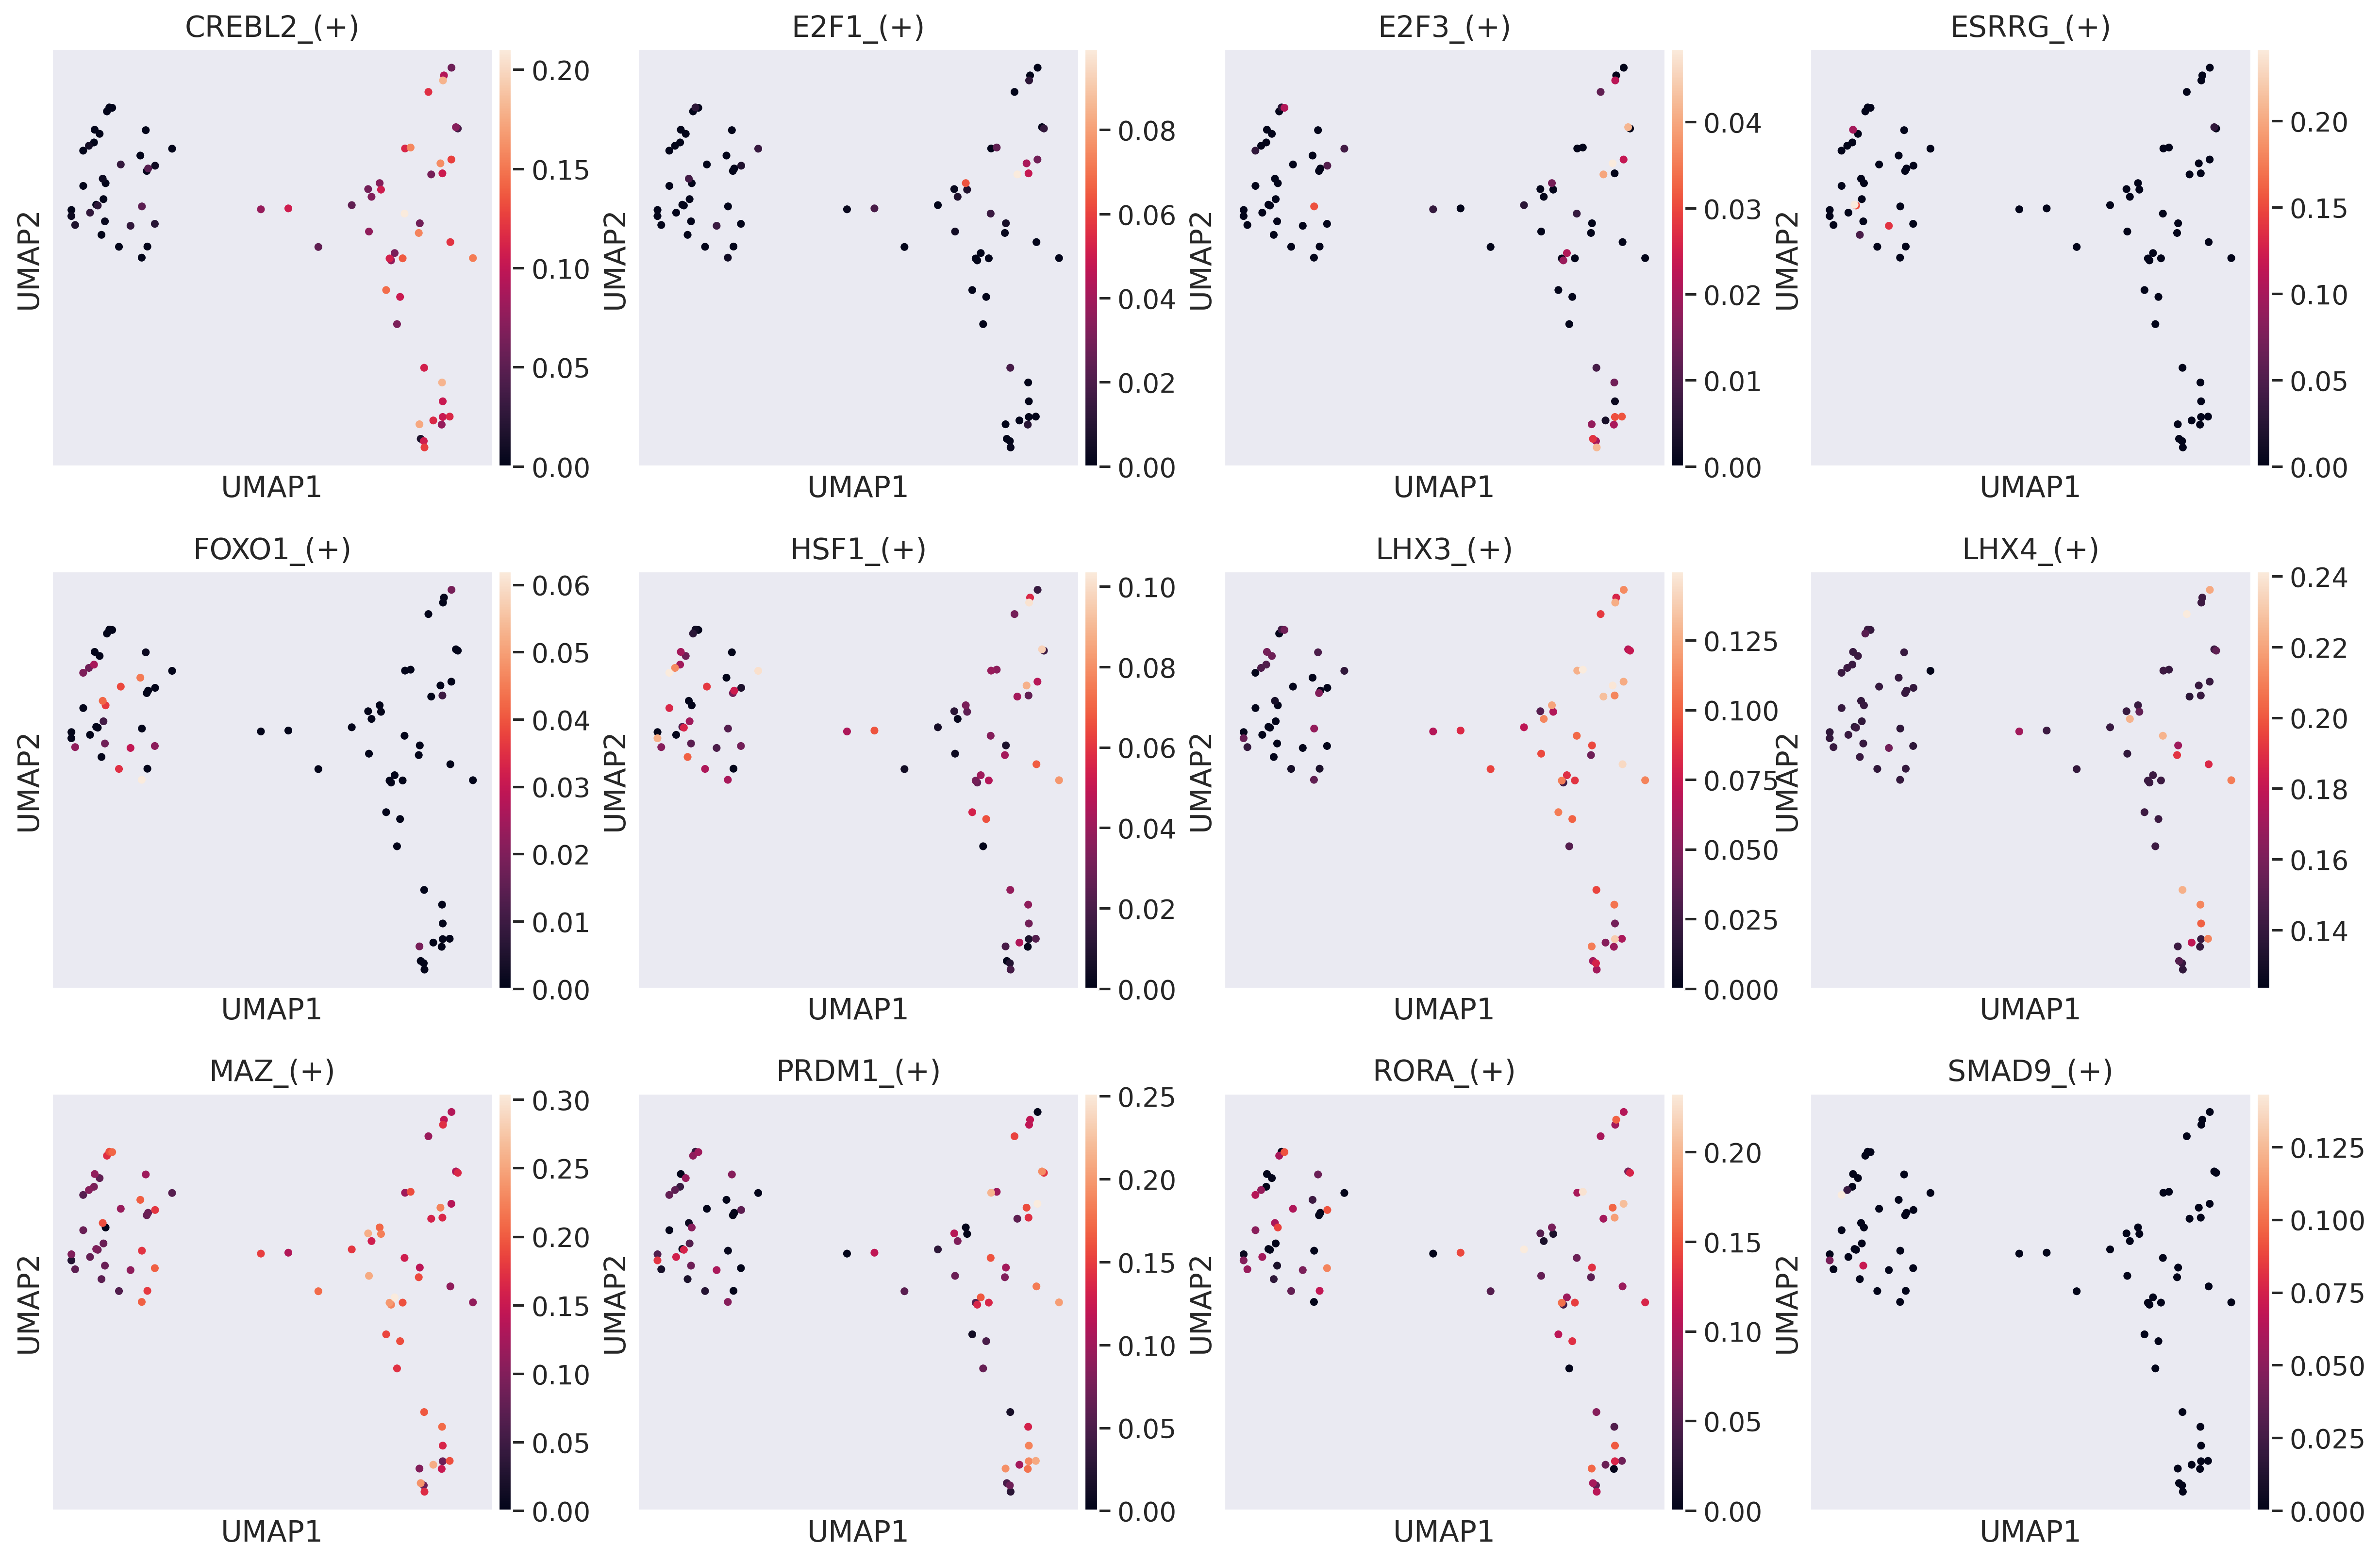

In [76]:
sc.pl.umap(adata_h5ad, color=auc_mtx.columns, size=60, save='.pdf')